https://www.analyticsvidhya.com/blog/2022/07/sentiment-analysis-using-python/

In [1]:
import pandas as pd
import nltk
from nltk.stem import PorterStemmer
import re
from textblob import Word #for lemmatization
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

In [3]:
df = pd.read_csv('data.csv')

In [4]:
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [5]:
encoder = LabelEncoder()
df['Sentiment']=encoder.fit_transform(df['Sentiment'])

<AxesSubplot:>

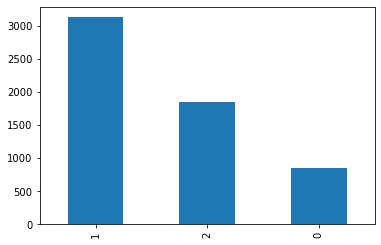

In [6]:
df['Sentiment'].value_counts().plot.bar()

# Preprocessing

https://bobbyhadz.com/blog/python-remove-non-alphanumeric-characters-from-string

In [7]:
def cleaning(df, stop_words):
    #text to lowercase
    df['Sentence'] = df['Sentence'].apply(lambda x: ' '.join(x.lower() for x in x.split()))
    # Replacing the digits/numbers/non-alphanumeric characters
    df['Sentence'] = df['Sentence'].apply(lambda x: re.sub(r'[^A-Za-z\s]', '', x))
    # Removing stop words
    df['Sentence'] = df['Sentence'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))
    # Stemming
    stemmer = PorterStemmer()
    df['Sentence'] = df['Sentence'].apply(lambda x: ' '.join([stemmer.stem(x) for x in x.split()]))
    return df

https://www.projectpro.io/recipes/add-custom-stopwords-and-then-remove-them-from-text 

In [8]:
stop_words = stopwords.words('english')
new_stopwords = ["company"]
stop_words.extend(new_stopwords)
data_cleaned = cleaning(df, stop_words)

In [9]:
data_cleaned.head()

,Sentence,Sentiment
0,geosolut technolog leverag benefon gp solut pr...,2
1,esi low bk real possibl,0
2,last quarter componenta net sale doubl eurm eu...,2
3,accord finnishrussian chamber commerc major co...,1
4,swedish buyout firm sold remain percent stake ...,1


In [10]:
data_cleaned.dtypes

Sentence     object
Sentiment     int64
dtype: object

# Word Embedding

In [11]:
tokenizer = Tokenizer(num_words = 500, split = ' ') #by default, this tokenizer converts text to lowercase
tokenizer.fit_on_texts(data_cleaned['Sentence'].values) #to pass as an array using 'values'
X = tokenizer.texts_to_sequences(data_cleaned['Sentence'].values)

In [12]:
len(X)

5842

In [13]:
X = pad_sequences(X) #here, sequences will be padded to the length of the longest individual sequence
#by default, pre padding is done

In [14]:
X

array([[  0,   0,   0, ..., 222, 392, 248],
       [  0,   0,   0, ...,   0, 310, 360],
       [  0,   0,   0, ..., 193,  26,  79],
       ...,
       [  0,   0,   0, ..., 108, 307,  55],
       [  0,   0,   0, ...,  48,   1,   2],
       [  0,   0,   0, ..., 197, 183, 188]], dtype=int32)

# Model Building

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, data_cleaned['Sentiment'], test_size=0.20, random_state=42)

In [16]:
num_classes = 3

In [17]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [18]:
Vocab_size = 500

- https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

In [19]:
model = tf.keras.Sequential()
model.add(Embedding(Vocab_size, 120))#120 is the output dimension
model.add(LSTM(704))#704 dimensional output for each word given as input
model.add(Dense(3, activation='softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 120)         60000     
_________________________________________________________________
lstm (LSTM)                  (None, 704)               2323200   
_________________________________________________________________
dense (Dense)                (None, 3)                 2115      
Total params: 2,385,315
Trainable params: 2,385,315
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [22]:
model.fit(X_train, y_train, epochs = 15, batch_size=32)

Epoch 1/15
147/147 [==============================] - 67s 438ms/step - loss: 0.9265 - accuracy: 0.5786
Epoch 2/15
147/147 [==============================] - 83s 563ms/step - loss: 0.7189 - accuracy: 0.6837
Epoch 3/15
147/147 [==============================] - 64s 435ms/step - loss: 0.6619 - accuracy: 0.7124
Epoch 4/15
147/147 [==============================] - 61s 413ms/step - loss: 0.6260 - accuracy: 0.7210
Epoch 5/15
147/147 [==============================] - 61s 414ms/step - loss: 0.5889 - accuracy: 0.7323
Epoch 6/15
147/147 [==============================] - 62s 423ms/step - loss: 0.5693 - accuracy: 0.7468
Epoch 7/15
147/147 [==============================] - 62s 421ms/step - loss: 0.5381 - accuracy: 0.7586
Epoch 8/15
147/147 [==============================] - 70s 476ms/step - loss: 0.5068 - accuracy: 0.7665
Epoch 9/15
147/147 [==============================] - 64s 435ms/step - loss: 0.4856 - accuracy: 0.7759
Epoch 10/15
147/147 [==============================] - 65s 443ms/step - l

In [23]:
model.evaluate(X_test,y_test)

37/37 [==============================] - 7s 168ms/step - loss: 1.2530 - accuracy: 0.6724


[1.252974033355713, 0.6723695397377014]

While optimization, we use a function to evaluate the weights and try to minimize the error. This objective function is our loss function and the evaluation score calculated by this loss function is called loss